# **Univerdidad Pontificia de Comillas  ICAI**


> Professor: Abran Yiu-Sen Yuen Durán <br>
> Group:<br>
> Students:<br>
> Deep Learning 2024-2025 <br>
> Unit 4 ASSESTMENT Food<br>

# Libraries

In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# Preparation

### 1. Define Device for Computation

In [19]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


### 2. Load and Explore Dataset

In [20]:
# File path to CSV
file_path = r'C:\Users\javia\OneDrive\Belgeler\Javi\Universidad\2 CURSO\Deep Learning\Assignment4Food\UNIMIB2016\percentage.csv'

# Read the CSV file
porcentage = pd.read_csv(file_path)
print("Dataset shape:", porcentage.shape)
print(porcentage.head())

Dataset shape: (1027, 2)
            image_name  food_pixels
0  20151127_114556.jpg     8.847947
1  20151127_114946.jpg    20.754738
2  20151127_115133.jpg    13.383787
3  20151127_115151.jpg    16.034561
4  20151127_115229.jpg    17.368320


### 3. Split Dataset into Training, Validation and Test sets

In [21]:
seed = 282  # Fix seed for reproducibility
torch.manual_seed(seed)

# Train/test/validation split
train_size = int(0.7 * len(porcentage))
test_val_size = len(porcentage) - train_size

# Random split
train_data_csv, test_val_data_csv = random_split(porcentage, [train_size, test_val_size])

# Further split test/validation
test_size = len(test_val_data_csv) // 2
val_size = len(test_val_data_csv) - test_size
val_data_csv, test_data_csv = random_split(test_val_data_csv, [val_size, test_size])

print('Dimension datos de train:', len(train_data_csv))
print('Dimension datos de validation:', len(val_data_csv))
print('Dimension datos de test:', len(test_data_csv))

Dimension datos de train: 718
Dimension datos de validation: 155
Dimension datos de test: 154


### 4. Define Custom Dataset class

In [22]:
# Custom Dataset class for loading images and labels
class FoodDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image_name']
        label = row['food_pixels']
        
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)


### 5. Define Image Transformation

In [23]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((155, 155)),
    transforms.RandomRotation(160),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])


### 6. Create Data Loaders

In [24]:
# Creating datasets
img_dir = r'C:\Users\javia\OneDrive\Belgeler\Javi\Universidad\2 CURSO\Deep Learning\Assignment4Food\UNIMIB2016\images'

# Convert Subsets to DataFrames for compatibility
train_df = pd.DataFrame([porcentage.iloc[i] for i in train_data_csv.indices])
val_df = pd.DataFrame([porcentage.iloc[i] for i in val_data_csv.indices])
test_df = pd.DataFrame([porcentage.iloc[i] for i in test_data_csv.indices])

train_dataset = FoodDataset(train_df, img_dir, transform)
val_dataset = FoodDataset(val_df, img_dir, transform)
test_dataset = FoodDataset(test_df, img_dir, transform)

# DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 7. Visualize Sample images from Dataset

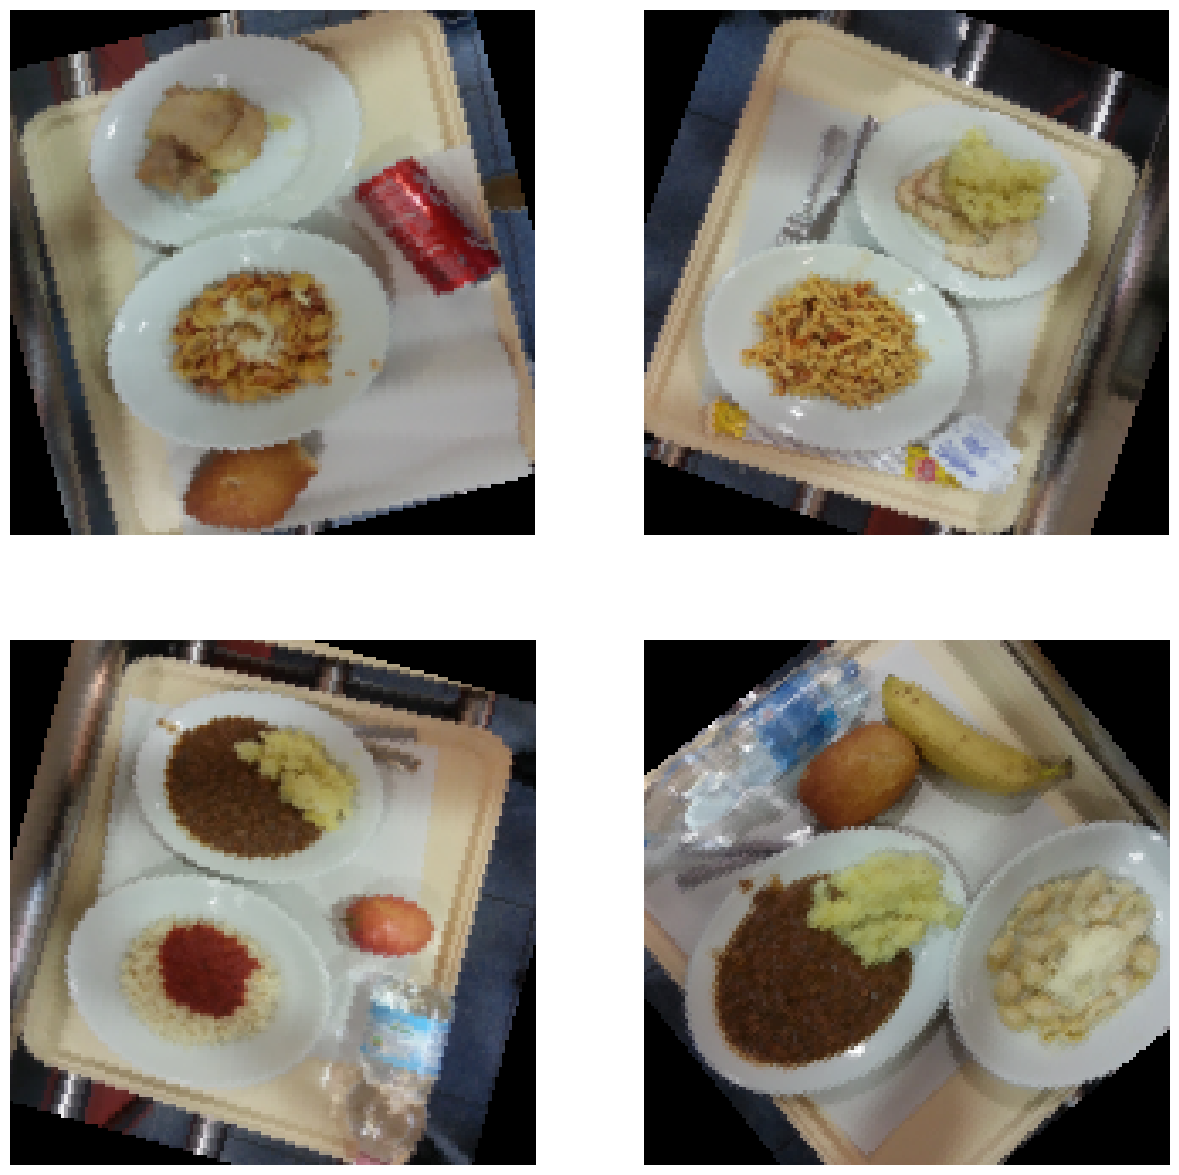

In [25]:
# Visualize sample images
def show_random_images(loader):
    # Get a batch of data
    images, labels = next(iter(loader))
    
    # Undo normalization to get pixel values between 0 and 1
    images = (images * 0.5) + 0.5
    
    # Choose 4 random indices
    idx = random.randint(0, len(images) - 4)
    
    fig, axarr = plt.subplots(2, 2, figsize=(15, 15))
    for i, ax in enumerate(axarr.flat):
        img = images[idx + i].permute(1, 2, 0).numpy()  # Convert to (H, W, C) for display
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Show random images from the train set
show_random_images(train_loader)

### 8. Visualize Pixel Intensity Distribution

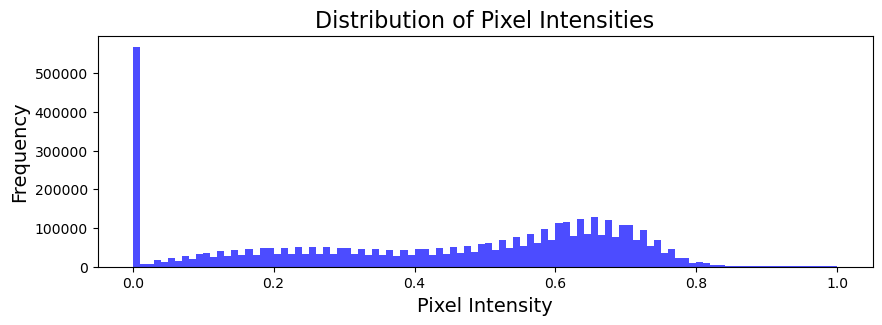

In [26]:
# Visualize pixel intensity distribution
def plot_pixel_distribution(loader):
    images, labels = next(iter(loader))
    # Undo normalization to get pixel values in range [0, 1]
    images = (images * 0.5) + 0.5

    # Flatten the pixels across all images in the batch
    flattened_pixels = images.numpy().reshape(-1)

    # Plot the histogram of pixel intensities
    plt.figure(figsize=(10, 3))
    plt.hist(flattened_pixels, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Pixel Intensity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Pixel Intensities', fontsize=16)
    plt.show()

# Plot pixel intensity distribution for train data
plot_pixel_distribution(train_loader)


# Model and validation.
From this point you simply have to create a model which best solves the problem. Each member of the team must solve with a different model. It doesn't have to be one better than the other, just that you are able to design and explain a different model. All types of models are accepted, including transfer learning, where VGG16 usually gives good results.

### 1. Define Transfer Learning Model and memory optimization

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self, base_model='mobilenet_v2'):
        super(TransferLearningModel, self).__init__()
        if base_model == 'resnet18':
            from torchvision.models import resnet18, ResNet18_Weights
            self.base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
            num_ftrs = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()  # Remove the last FC Layer
        elif base_model == 'mobilenet_v2':
            from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
            self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
            num_ftrs = self.base_model.classifier[1].in_features
            self.base_model.classifier[1] = nn.Identity()
        else:
            raise ValueError(f"Modelo base no soportado: {base_model}")
        
        # Simplified regression head to reduce memory usage
        self.regressor = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        features = self.base_model(x)
        output = self.regressor(features)
        return output.squeeze(1)

# Memory optimization: enable cuDNN benchmark
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Optional: transform definitions for Transfer Learning
img_size = 160
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# You can update your datasets with these transforms if you wish.

In [28]:
# Clean up memory between epochs
def clean_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

### 2. Training and Validation function

In [29]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_losses = []
    val_losses = []
    val_rmses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_batches = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_batches += 1
            
        avg_train_loss = running_loss / train_batches
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        val_batches = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_batches += 1
                
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        avg_val_loss = running_val_loss / val_batches
        val_losses.append(avg_val_loss)
        val_rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
        val_rmses.append(val_rmse)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_food_percentage_model.pth')
            print(f"Modelo guardado en epoch {epoch+1} con val loss: {best_val_loss:.4f}")
            
    model.load_state_dict(torch.load('best_food_percentage_model.pth'))
    return train_losses, val_losses, val_rmses


### 3. Test Function

In [30]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    test_batches = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item()
            test_batches += 1
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_test_loss = running_test_loss / test_batches
    test_mse = mean_squared_error(all_labels, all_preds)
    test_rmse = np.sqrt(test_mse)
    
    print(f"Test Loss (MSE): {avg_test_loss:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
    return test_rmse, all_preds, all_labels


### 4. Model Training

In [ ]:
print("Starting training...")

# Important: move the model to the device before creating the optimizer
model = TransferLearningModel(base_model='mobilenet_v2').to(device)
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
criterion = nn.MSELoss()

train_losses, val_losses, val_rmses = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    num_epochs=30
)

Starting training...


Epoch 1/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch 1/30 - Train Loss: 144.0751, Val Loss: 50.6248, Val RMSE: 7.0089
Modelo guardado en epoch 1 con val loss: 50.6248


Epoch 2/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Epoch 2/30 - Train Loss: 18.0947, Val Loss: 25.0945, Val RMSE: 4.9156
Modelo guardado en epoch 2 con val loss: 25.0945


Epoch 3/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Epoch 3/30 - Train Loss: 11.3050, Val Loss: 7.7994, Val RMSE: 2.6957
Modelo guardado en epoch 3 con val loss: 7.7994


Epoch 4/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 4/30 - Train Loss: 8.4088, Val Loss: 4.0001, Val RMSE: 1.9780
Modelo guardado en epoch 4 con val loss: 4.0001


Epoch 5/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Epoch 5/30 - Train Loss: 7.4777, Val Loss: 6.0722, Val RMSE: 2.2384


Epoch 6/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch 6/30 - Train Loss: 6.7422, Val Loss: 6.0575, Val RMSE: 2.4812


Epoch 7/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Epoch 7/30 - Train Loss: 6.3893, Val Loss: 4.7842, Val RMSE: 2.1366


Epoch 8/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch 8/30 - Train Loss: 5.9557, Val Loss: 4.6590, Val RMSE: 2.1457


Epoch 9/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch 9/30 - Train Loss: 5.6193, Val Loss: 2.8681, Val RMSE: 1.6753
Modelo guardado en epoch 9 con val loss: 2.8681


Epoch 10/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 10/30 - Train Loss: 5.3560, Val Loss: 3.4823, Val RMSE: 1.7972


Epoch 11/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch 11/30 - Train Loss: 5.4078, Val Loss: 3.7305, Val RMSE: 1.8952


Epoch 12/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Epoch 12/30 - Train Loss: 5.0568, Val Loss: 2.7872, Val RMSE: 1.6813
Modelo guardado en epoch 12 con val loss: 2.7872


Epoch 13/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 13/30 - Train Loss: 4.6937, Val Loss: 3.0927, Val RMSE: 1.7583


Epoch 14/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch 14/30 - Train Loss: 3.9705, Val Loss: 3.3078, Val RMSE: 1.8159


Epoch 15/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 15/30 - Train Loss: 4.9072, Val Loss: 3.2182, Val RMSE: 1.7564


Epoch 16/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Epoch 16/30 - Train Loss: 4.5579, Val Loss: 2.7971, Val RMSE: 1.6587


Epoch 17/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Epoch 17/30 - Train Loss: 4.4802, Val Loss: 2.4836, Val RMSE: 1.6665
Modelo guardado en epoch 17 con val loss: 2.4836


Epoch 18/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch 18/30 - Train Loss: 4.1191, Val Loss: 2.4787, Val RMSE: 1.5474
Modelo guardado en epoch 18 con val loss: 2.4787


Epoch 19/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch 19/30 - Train Loss: 4.5807, Val Loss: 3.6126, Val RMSE: 1.9159


Epoch 20/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch 20/30 - Train Loss: 4.1251, Val Loss: 2.6835, Val RMSE: 1.6402


Epoch 21/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch 21/30 - Train Loss: 5.2116, Val Loss: 2.2223, Val RMSE: 1.5094
Modelo guardado en epoch 21 con val loss: 2.2223


Epoch 22/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch 22/30 - Train Loss: 4.1915, Val Loss: 1.7466, Val RMSE: 1.3372
Modelo guardado en epoch 22 con val loss: 1.7466


Epoch 23/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch 23/30 - Train Loss: 4.2010, Val Loss: 2.4639, Val RMSE: 1.5142


Epoch 24/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch 24/30 - Train Loss: 3.7677, Val Loss: 2.2616, Val RMSE: 1.4923


Epoch 25/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch 25/30 - Train Loss: 3.3043, Val Loss: 1.8388, Val RMSE: 1.3408


Epoch 26/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch 26/30 - Train Loss: 3.4368, Val Loss: 2.0264, Val RMSE: 1.4455


Epoch 27/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch 27/30 - Train Loss: 3.8895, Val Loss: 1.8704, Val RMSE: 1.3934


Epoch 28/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch 28/30 - Train Loss: 4.1127, Val Loss: 2.9129, Val RMSE: 1.7460


Epoch 29/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 29/30 - Train Loss: 4.4896, Val Loss: 1.6854, Val RMSE: 1.2612
Modelo guardado en epoch 29 con val loss: 1.6854


Epoch 30/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

Epoch 30/30 - Train Loss: 4.0253, Val Loss: 1.1469, Val RMSE: 1.1095
Modelo guardado en epoch 30 con val loss: 1.1469



C:\Users\javia\AppData\Local\Temp\ipykernel_36780\880840727.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_food_percentage_mode

### 5. Loss and RMSE Graphs

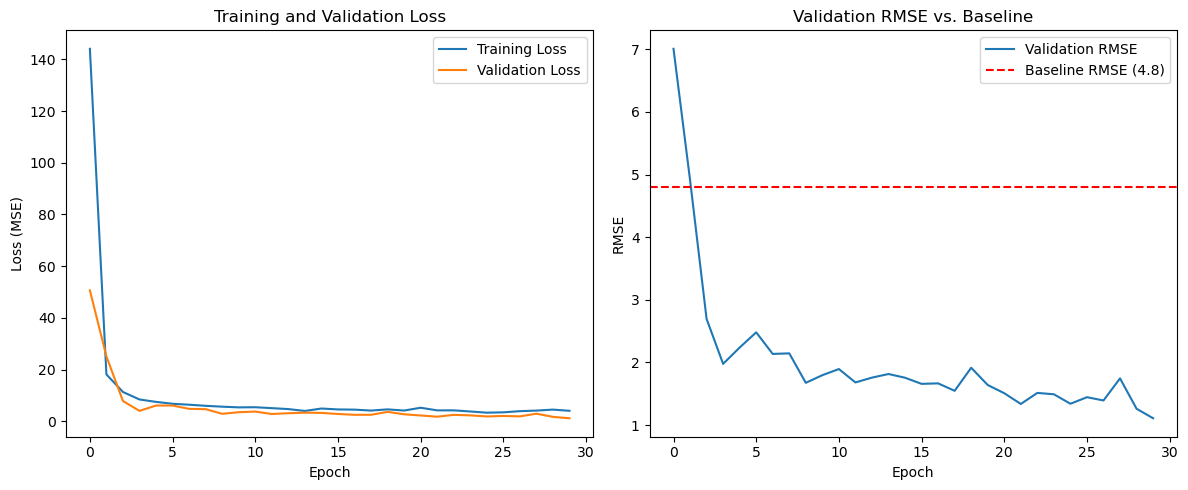

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_rmses, label='Validation RMSE')
plt.axhline(y=4.8, color='r', linestyle='--', label='Baseline RMSE (4.8)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE vs. Baseline')
plt.legend()

plt.tight_layout()
plt.show()

### 6. Test evaluation

In [33]:
test_rmse, all_preds, all_labels = evaluate_model(model, test_loader, criterion)

Testing: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

Test Loss (MSE): 2.1325
Test RMSE: 1.4800


### 7. Predictions vs actual values

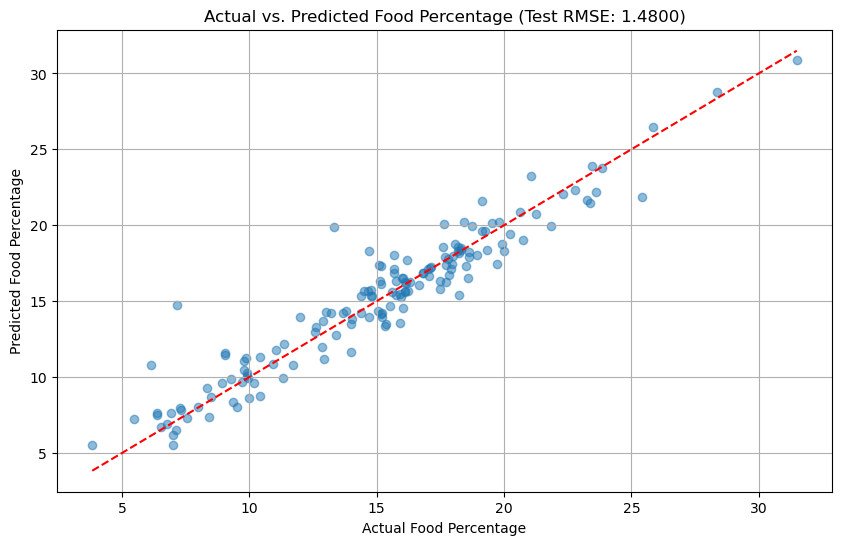

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')
plt.xlabel('Actual Food Percentage')
plt.ylabel('Predicted Food Percentage')
plt.title(f'Actual vs. Predicted Food Percentage (Test RMSE: {test_rmse:.4f})')
plt.grid(True)
plt.show()

### 8. Visualization Model Predictions

C:\Users\javia\AppData\Local\Temp\ipykernel_36780\1994504993.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_food_percentage_mode

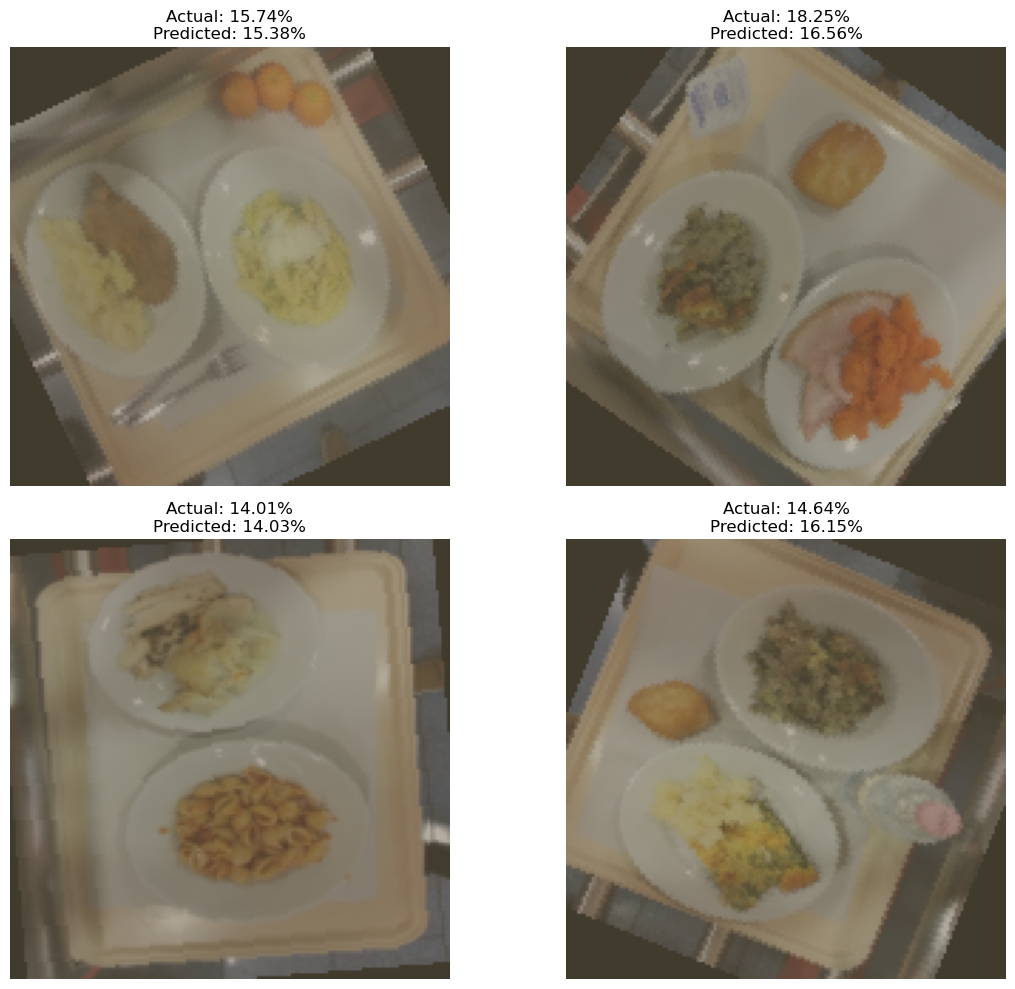

In [35]:
def visualize_predictions_simple(model, test_loader, num_examples=4):
    # Set model to evaluation mode
    model.eval()

    # Get a batch of data
    images, labels = next(iter(test_loader))

    # Move images to same device as model
    device = next(model.parameters()).device
    images = images.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)

    # Convert to numpy
    predictions = outputs.cpu().numpy()
    actual = labels.numpy()

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(min(num_examples, len(images))):
        # Denormalize image
        img = images[i].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Display image with predictions
        axes[i].imshow(img)
        axes[i].set_title(f"Actual: {actual[i]:.2f}%\nPredicted: {predictions[i]:.2f}%")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Make sure model is loaded
model.load_state_dict(torch.load('best_food_percentage_model.pth'))
model = model.to(device)

# Call the simplified function
visualize_predictions_simple(model, test_loader)